# FROZEN PRODUCT AMOUNT FORECAST BY TIME

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# 1. Libraries|User Defined Functions

## 1.1. Import Libraries

In [ ]:
# !pip install pyforest
# 1-Import Libraies
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import missingno as msno 

from sklearn.compose import make_column_transformer

# Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# !pip install termcolor
import colorama
from colorama import Fore, Style  # maakes strings colored
from termcolor import colored

import ipywidgets
from ipywidgets import interact

## 1.2. Some Useful User Defined Functions

In [2]:
## Some Useful Functions

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)
    
###############################################################################

# 2. Read dataset

In [3]:
df0 = pd.read_csv("Frozen_Dessert_Production.csv",
                   index_col='DATE',
                   parse_dates=True)
df = df0.copy()
df.head()
first_looking(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)
# df.head()
# df.describe().T
# df.describe(include=object).T

Shape:(573, 1)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB
None
-------------------------------------------------------------------------------
Number of Uniques:
IPN31152N    573
dtype: int64
-------------------------------------------------------------------------------
Missing Values:
Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []
-------------------------------------------------------------------------------
All Columns:['IPN31152N']
-------------------------------------------------------------------------------
Columns after rename:['ipn31152n']
-------------------------------------------------------------------------------
Duplicate check

In [4]:
df = df.rename(columns={'ipn31152n':'amount'})

In [5]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [6]:
df.tail()

,amount
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
amount,573.000,109.896,27.951,58.660,88.936,107.643,128.278,196.174


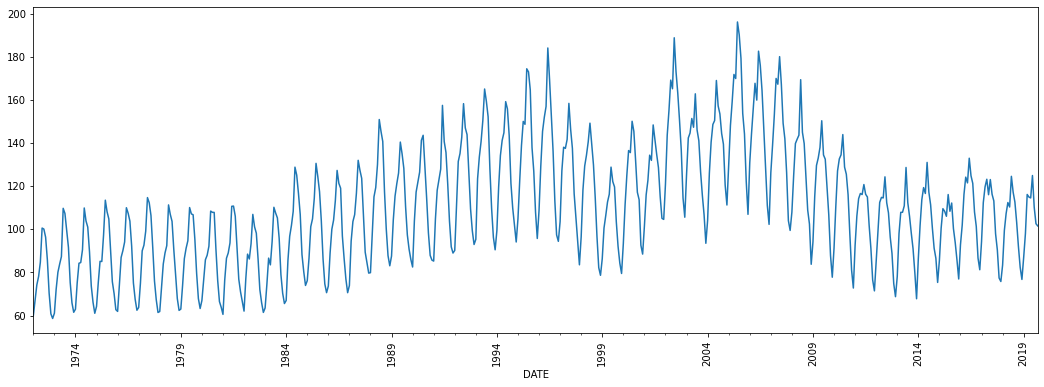

In [8]:
df['amount'].plot(figsize=(18,6))
plt.xticks(rotation=90);

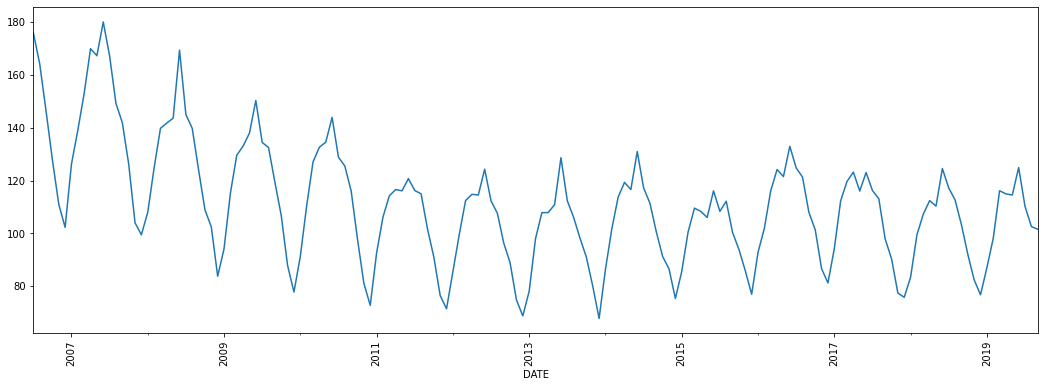

In [9]:
df['amount'].loc["2006-06-30" : "2019-09-01"].plot(figsize=(18,6))
plt.xticks(rotation=90);

### 3. Check missing values

In [10]:
missing_values(df)

,Missing_Number,Missing_Percent


### 4. Plot the distribution of various discrete features on (Season, haliday, weekend and weathercode)

In [11]:
df.head(2)

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061


In [12]:
df_ = df.copy()
df_["year"] = df_.index.year
df_['month'] = df_.index.month 
df_.head(2)

,amount,year,month
DATE,,,
1972-01-01,59.962,1972,1
1972-02-01,67.061,1972,2


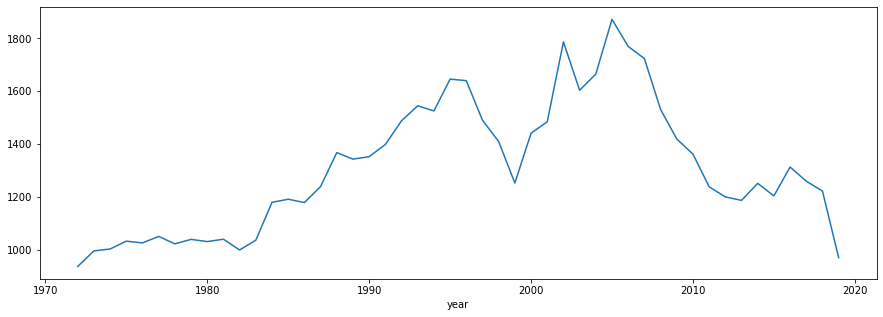

In [13]:
yearly_total_amount = df_.groupby("year")["amount"].sum()
plt.figure(figsize=(15,5))
sns.lineplot(yearly_total_amount.index, yearly_total_amount.values);

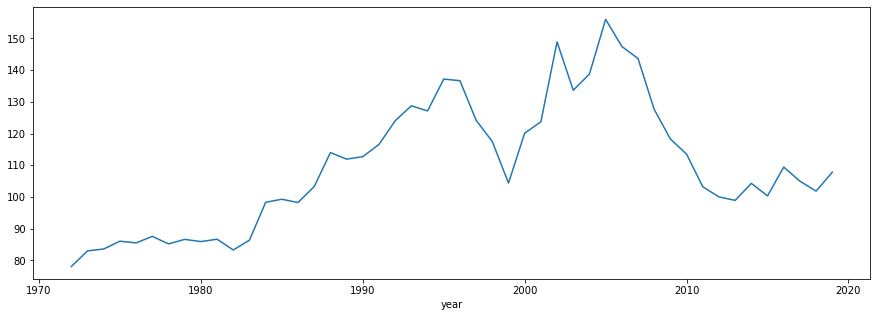

In [14]:
yearly_avg_amount = df_.groupby("year")["amount"].mean()
plt.figure(figsize=(15,5))
sns.lineplot(yearly_avg_amount.index, yearly_avg_amount.values);

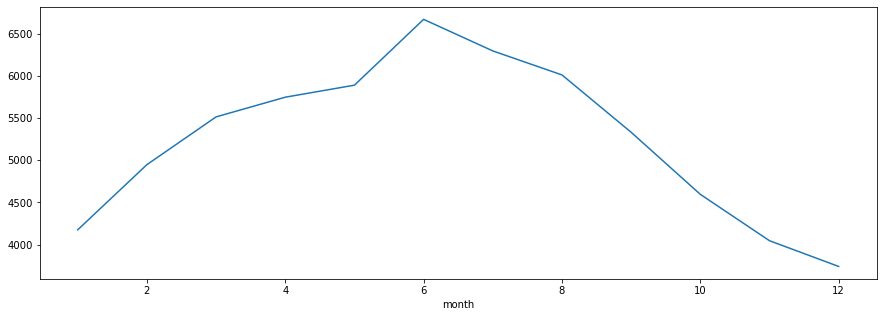

In [15]:
monthly_total_amount = df_.groupby("month")["amount"].sum()
plt.figure(figsize=(15,5))
sns.lineplot(monthly_total_amount.index, monthly_total_amount.values);

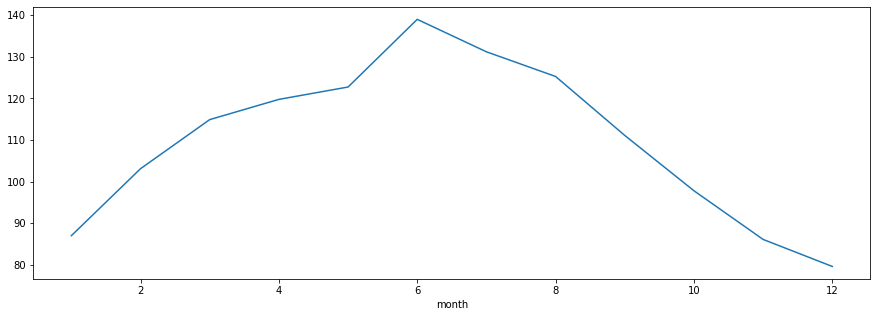

In [16]:
monthly_avg_amount = df_.groupby("month")["amount"].mean()
plt.figure(figsize=(15,5))
sns.lineplot(monthly_avg_amount.index, monthly_avg_amount.values);

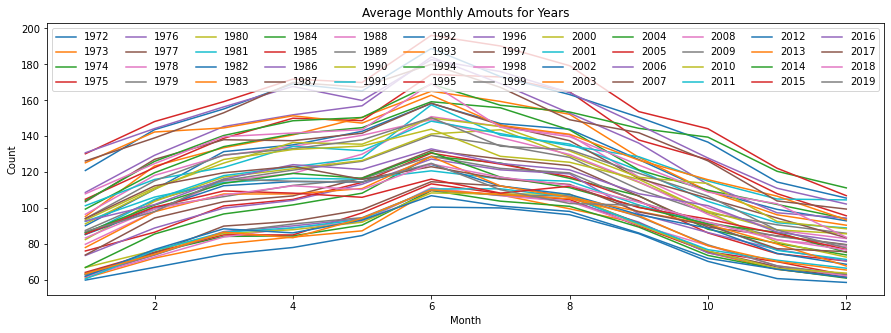

In [17]:
year_month_comp = df_.groupby(["year", "month"])["amount"].mean()

plt.figure(figsize=(15,5))
for i in year_month_comp.index.levels[0]:
    plt.plot(year_month_comp[i].index, year_month_comp[i], label=i)

plt.legend(loc='best', mode = "expand", ncol = 12)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Average Monthly Amouts for Years')
plt.show()

### 5. Preprocessing of Data

### Train Test Split

In [18]:
len(df)

573

In [19]:
test_size = 72

In [20]:
test_ind = len(df)- test_size
test_ind 

501

In [21]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [22]:
train.head(2)

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061


In [23]:
test.head(2)

,amount
DATE,
2013-10-01,90.998
2013-11-01,80.069


### Scaling

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler()

In [26]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

### Time Series Generator

In [27]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [28]:
# help(TimeseriesGenerator)

In [29]:
length = 24
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [30]:
generator[0]

(array([[[-1.7428696 ],
         [-1.49951581],
         [-1.25354961],
         [-1.1206329 ],
         [-0.8925935 ],
         [-0.34980513],
         [-0.36590803],
         [-0.49500557],
         [-0.85703819],
         [-1.38525269],
         [-1.71390014],
         [-1.78752029],
         [-1.70387568],
         [-1.32310376],
         [-1.05253237],
         [-0.92199836],
         [-0.80319612],
         [-0.03608809],
         [-0.11740487],
         [-0.3817881 ],
         [-0.65728601],
         [-1.21686981],
         [-1.53812919],
         [-1.68910639]]]),
 array([[-1.6394229]]))

In [32]:
train_scaled[0:25]

array([[-1.7428696 ],
       [-1.49951581],
       [-1.25354961],
       [-1.1206329 ],
       [-0.8925935 ],
       [-0.34980513],
       [-0.36590803],
       [-0.49500557],
       [-0.85703819],
       [-1.38525269],
       [-1.71390014],
       [-1.78752029],
       [-1.70387568],
       [-1.32310376],
       [-1.05253237],
       [-0.92199836],
       [-0.80319612],
       [-0.03608809],
       [-0.11740487],
       [-0.3817881 ],
       [-0.65728601],
       [-1.21686981],
       [-1.53812919],
       [-1.68910639],
       [-1.6394229 ]])

In [33]:
X, y = generator[0]

In [34]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-1.7428696  -1.49951581 -1.25354961 -1.1206329  -0.8925935  -0.34980513
 -0.36590803 -0.49500557 -0.85703819 -1.38525269 -1.71390014 -1.78752029
 -1.70387568 -1.32310376 -1.05253237 -0.92199836 -0.80319612 -0.03608809
 -0.11740487 -0.3817881  -0.65728601 -1.21686981 -1.53812919 -1.68910639]
Predict this y: 
 [[-1.6394229]]


## 6. Modelling & Model Performance

### Creating Model

### 6.1. With "tanh" activation function

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.layers import Dropout

In [99]:
n_features = 1

In [100]:
model = Sequential()
model.add(LSTM(56, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [101]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 56)                12992     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 57        
Total params: 13,049
Trainable params: 13,049
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [104]:
from tensorflow.keras.callbacks import EarlyStopping

In [105]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [106]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [107]:
len(validation_generator)

48

In [108]:
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
549/549 [==============================] - 18s 24ms/step - loss: 0.3663 - val_loss: 0.0487
Epoch 2/64
549/549 [==============================] - 12s 22ms/step - loss: 0.0782 - val_loss: 0.0677
Epoch 3/64
549/549 [==============================] - 11s 21ms/step - loss: 0.0673 - val_loss: 0.0549
Epoch 4/64
549/549 [==============================] - 10s 18ms/step - loss: 0.0593 - val_loss: 0.0364
Epoch 5/64
549/549 [==============================] - 12s 21ms/step - loss: 0.0612 - val_loss: 0.0329
Epoch 6/64
549/549 [==============================] - 10s 18ms/step - loss: 0.0543 - val_loss: 0.0417
Epoch 7/64
549/549 [==============================] - 10s 18ms/step - loss: 0.0526 - val_loss: 0.0390
Epoch 8/64
549/549 [==============================] - 10s 18ms/step - loss: 0.0474 - val_loss: 0.0450
Epoch 9/64
549/549 [==============================] - 10s 18ms/step - loss: 0.0467 - val_loss: 0.0824
Epoch 10/64
549/549 [==============================] - 11s 20ms/step - loss: 0.048

<AxesSubplot:>

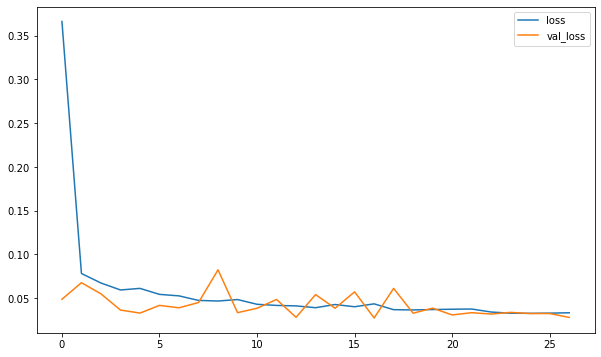

In [109]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [110]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [111]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [112]:
validation_generator[0]

(array([[[-0.67885026],
         [-1.05352659],
         [-1.47405696],
         [-0.83657786],
         [-0.31090033],
         [ 0.10203626],
         [ 0.29325874],
         [ 0.1999222 ],
         [ 0.69390816],
         [ 0.22190814],
         [ 0.02120974],
         [-0.34907146],
         [-0.66982345],
         [-0.83058513],
         [-1.21446997],
         [-0.86471081],
         [-0.35110789],
         [-0.04184085],
         [-0.08357059],
         [-0.16255953],
         [ 0.18301706],
         [-0.08302549],
         [ 0.04819762],
         [-0.35829712]]]),
 array([[-0.57827993]]))

In [113]:
len(validation_generator)

48

In [114]:
validation_generator[47]

(array([[[-0.44180461],
         [-0.69684904],
         [-1.14374677],
         [-1.19949156],
         [-0.93816641],
         [-0.38772599],
         [-0.11944816],
         [ 0.05593539],
         [-0.01525408],
         [ 0.4725883 ],
         [ 0.2201734 ],
         [ 0.06440338],
         [-0.25669829],
         [-0.63997632],
         [-0.97243609],
         [-1.16695662],
         [-0.81596326],
         [-0.43497878],
         [ 0.18418613],
         [ 0.14299463],
         [ 0.12897272],
         [ 0.48549257],
         [-0.01838072],
         [-0.2808098 ]]]),
 array([[-0.315844]]))

In [115]:
y_pred = model.predict(validation_generator)
y_pred

array([[-0.7614275 ],
       [-0.9389263 ],
       [-1.0818434 ],
       [-1.0064511 ],
       [-0.2520855 ],
       [ 0.08287249],
       [ 0.38088503],
       [ 0.62386423],
       [ 0.7038199 ],
       [ 0.6011767 ],
       [ 0.2562261 ],
       [-0.07786512],
       [-0.49529734],
       [-0.64276224],
       [-0.95134234],
       [-0.6845146 ],
       [-0.17466116],
       [ 0.26576048],
       [ 0.44623563],
       [ 0.60426044],
       [ 0.5507097 ],
       [ 0.3377038 ],
       [-0.0058451 ],
       [-0.3038308 ],
       [-0.782139  ],
       [-0.9547068 ],
       [-1.2000258 ],
       [-0.86192834],
       [-0.47253218],
       [-0.07083581],
       [ 0.06147759],
       [ 0.2352496 ],
       [ 0.26808307],
       [ 0.26806942],
       [ 0.02037485],
       [-0.3515277 ],
       [-0.690895  ],
       [-0.99586916],
       [-1.1121937 ],
       [-0.88128257],
       [-0.2910932 ],
       [ 0.01761646],
       [ 0.31683573],
       [ 0.42002127],
       [ 0.5425883 ],
       [ 0

In [116]:
len(y_pred)

48

In [117]:
len(test_scaled)

72

In [118]:
len(test_scaled[24:])

48

In [119]:
test_scaled[24:]

array([[-0.57827993],
       [-0.85486805],
       [-1.15961655],
       [-0.61671847],
       [-0.30255233],
       [ 0.18444325],
       [ 0.45978345],
       [ 0.36834622],
       [ 0.76065107],
       [ 0.48175225],
       [ 0.36109871],
       [-0.09474012],
       [-0.32280353],
       [-0.82741734],
       [-1.01281507],
       [-0.56752523],
       [ 0.0544612 ],
       [ 0.30508308],
       [ 0.42610345],
       [ 0.18047323],
       [ 0.42126264],
       [ 0.18734363],
       [ 0.08133252],
       [-0.44180461],
       [-0.69684904],
       [-1.14374677],
       [-1.19949156],
       [-0.93816641],
       [-0.38772599],
       [-0.11944816],
       [ 0.05593539],
       [-0.01525408],
       [ 0.4725883 ],
       [ 0.2201734 ],
       [ 0.06440338],
       [-0.25669829],
       [-0.63997632],
       [-0.97243609],
       [-1.16695662],
       [-0.81596326],
       [-0.43497878],
       [ 0.18418613],
       [ 0.14299463],
       [ 0.12897272],
       [ 0.48549257],
       [-0

In [120]:
eval_metrics(test_scaled[24:], y_pred)

r2_score: 0.9014367311085036 
 mae: 0.13147471595957252 
 mse: 0.027938440614395252 
 rmse: 0.1671479602459906


In [121]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [122]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.6224550200794395 
 mae: 0.27587442165826737 
 mse: 0.10695289591198215 
 rmse: 0.32703653605061034


#### Inverse Transformations and Comparing

In [123]:
true_predictions = scaler.inverse_transform(test_predictions)

In [124]:
test.head()

,amount,prediction,predictions_relu
DATE,,,
2013-10-01,90.998,86.144,91.578
2013-11-01,80.069,78.003,82.793
2013-12-01,67.803,77.662,81.973
2014-01-01,86.397,89.039,91.903
2014-02-01,101.731,104.732,104.663


In [125]:
test['prediction'] = true_predictions

In [126]:
test.head()

,amount,prediction,predictions_relu
DATE,,,
2013-10-01,90.998,84.832,91.578
2013-11-01,80.069,74.286,82.793
2013-12-01,67.803,70.972,81.973
2014-01-01,86.397,79.750,91.903
2014-02-01,101.731,94.965,104.663


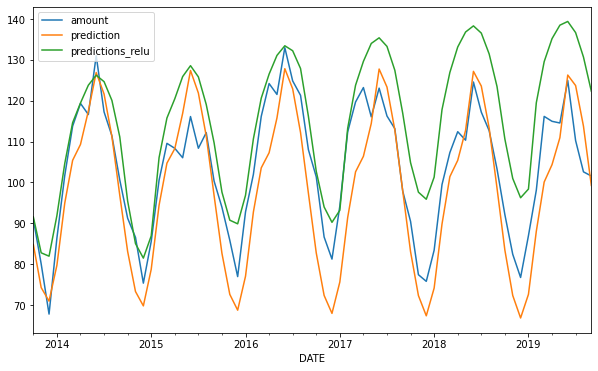

In [127]:
test.plot();

#### Calculation R2 Score and Error Metrics

In [128]:
eval_metrics(test.amount, test.prediction)

r2_score: 0.6224549887049985 
 mae: 8.046882735527888 
 mse: 90.99657044650164 
 rmse: 9.539212255029323


### 6.2. With "relu" activation function

In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

n_features = 1
model = Sequential()

model.add(LSTM(56, activation = 'relu', input_shape = (length, n_features))) 
model.add(Dense(1)) 

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 56)                12992     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 57        
Total params: 13,049
Trainable params: 13,049
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [130]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
len(validation_generator)

48

In [131]:
model.fit_generator(generator, epochs = 64,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/64
549/549 [==============================] - 15s 22ms/step - loss: 0.5264 - val_loss: 0.2221
Epoch 2/64
549/549 [==============================] - 13s 23ms/step - loss: 0.3958 - val_loss: 0.1248
Epoch 3/64
549/549 [==============================] - 12s 22ms/step - loss: 0.1688 - val_loss: 0.0927
Epoch 4/64
549/549 [==============================] - 11s 20ms/step - loss: 0.1085 - val_loss: 0.0582
Epoch 5/64
549/549 [==============================] - 11s 20ms/step - loss: 0.0932 - val_loss: 0.0488
Epoch 6/64
549/549 [==============================] - 10s 17ms/step - loss: 0.0849 - val_loss: 0.0604
Epoch 7/64
549/549 [==============================] - 10s 17ms/step - loss: 0.0786 - val_loss: 0.0451
Epoch 8/64
549/549 [==============================] - 10s 17ms/step - loss: 0.0730 - val_loss: 0.0415
Epoch 9/64
549/549 [==============================] - 9s 17ms/step - loss: 0.0696 - val_loss: 0.0487
Epoch 10/64
549/549 [==============================] - 10s 17ms/step - loss: 0.0654

<AxesSubplot:>

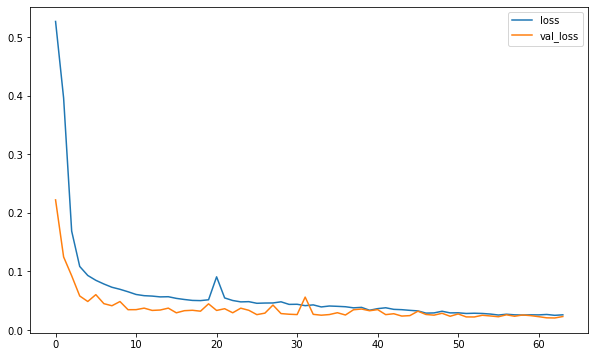

In [132]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [133]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [134]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [135]:
y_pred = model.predict(validation_generator)
y_pred

array([[-0.67288285],
       [-0.8638652 ],
       [-1.0708977 ],
       [-0.88139075],
       [-0.21084519],
       [-0.03555569],
       [ 0.28201014],
       [ 0.45854896],
       [ 0.91380113],
       [ 0.5223494 ],
       [ 0.26839694],
       [-0.0041482 ],
       [-0.39573455],
       [-0.6176785 ],
       [-1.0175673 ],
       [-0.6636732 ],
       [ 0.05304014],
       [ 0.31888855],
       [ 0.42979264],
       [ 0.5168596 ],
       [ 0.4859169 ],
       [ 0.24810761],
       [ 0.03727709],
       [-0.23293169],
       [-0.69549197],
       [-0.9186562 ],
       [-1.2673035 ],
       [-0.7681565 ],
       [-0.4221378 ],
       [-0.11980398],
       [ 0.05340225],
       [ 0.15092234],
       [ 0.35099703],
       [ 0.26429906],
       [ 0.06541824],
       [-0.20978676],
       [-0.52555174],
       [-0.8870755 ],
       [-1.0476547 ],
       [-0.6774553 ],
       [-0.14246283],
       [ 0.02140548],
       [ 0.38027635],
       [ 0.35047013],
       [ 0.6345626 ],
       [ 0

In [136]:
test_scaled[24:]

array([[-0.57827993],
       [-0.85486805],
       [-1.15961655],
       [-0.61671847],
       [-0.30255233],
       [ 0.18444325],
       [ 0.45978345],
       [ 0.36834622],
       [ 0.76065107],
       [ 0.48175225],
       [ 0.36109871],
       [-0.09474012],
       [-0.32280353],
       [-0.82741734],
       [-1.01281507],
       [-0.56752523],
       [ 0.0544612 ],
       [ 0.30508308],
       [ 0.42610345],
       [ 0.18047323],
       [ 0.42126264],
       [ 0.18734363],
       [ 0.08133252],
       [-0.44180461],
       [-0.69684904],
       [-1.14374677],
       [-1.19949156],
       [-0.93816641],
       [-0.38772599],
       [-0.11944816],
       [ 0.05593539],
       [-0.01525408],
       [ 0.4725883 ],
       [ 0.2201734 ],
       [ 0.06440338],
       [-0.25669829],
       [-0.63997632],
       [-0.97243609],
       [-1.16695662],
       [-0.81596326],
       [-0.43497878],
       [ 0.18418613],
       [ 0.14299463],
       [ 0.12897272],
       [ 0.48549257],
       [-0

In [137]:
eval_metrics(test_scaled[24:], y_pred)

r2_score: 0.9183556907722962 
 mae: 0.11930268506197965 
 mse: 0.023142644420332537 
 rmse: 0.1521270666920668


In [138]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [139]:
eval_metrics(test_scaled, test_predictions)

r2_score: -4.1036525351243425 
 mae: 0.9217181504554703 
 mse: 1.4457891043205775 
 rmse: 1.2024097073462845


#### Inverse Transformations and Comparing

In [140]:
true_predictions_relu = scaler.inverse_transform(test_predictions)

In [141]:
test['predictions_relu'] = true_predictions_relu

In [142]:
test.head(2)

,amount,prediction,predictions_relu
DATE,,,
2013-10-01,90.998,84.832,88.798
2013-11-01,80.069,74.286,80.667


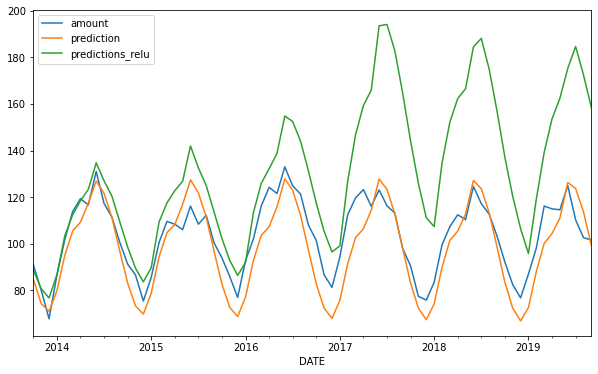

In [143]:
test.plot();

#### Calculation R2 Score and Error Metrics

In [144]:
eval_metrics(test.amount, test.predictions_relu)

r2_score: -4.103652688335893 
 mae: 26.88526721666124 
 mse: 1230.0914526606093 
 rmse: 35.07265961772231


## 7. Retrain and Forecasting

In [145]:
test

,amount,prediction,predictions_relu
DATE,,,
2013-10-01,90.998,84.832,88.798
2013-11-01,80.069,74.286,80.667
2013-12-01,67.803,70.972,76.716
2014-01-01,86.397,79.750,86.743
2014-02-01,101.731,94.965,103.346
2014-03-01,113.776,105.422,112.388
2014-04-01,119.353,109.310,118.458
2014-05-01,116.631,117.471,123.335
2014-06-01,131.040,126.905,134.726


In [146]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [147]:
length = 24 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [148]:
model = Sequential()

model.add(LSTM(55, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=64)

Epoch 1/64
549/549 [==============================] - 16s 21ms/step - loss: 0.3178
Epoch 2/64
549/549 [==============================] - 10s 18ms/step - loss: 0.0713
Epoch 3/64
549/549 [==============================] - 9s 17ms/step - loss: 0.0681
Epoch 4/64
549/549 [==============================] - 10s 17ms/step - loss: 0.0607
Epoch 5/64
549/549 [==============================] - 9s 17ms/step - loss: 0.0581
Epoch 6/64
549/549 [==============================] - 9s 17ms/step - loss: 0.0541
Epoch 7/64
549/549 [==============================] - 10s 18ms/step - loss: 0.0513
Epoch 8/64
549/549 [==============================] - 9s 17ms/step - loss: 0.0525
Epoch 9/64
549/549 [==============================] - 10s 17ms/step - loss: 0.0455
Epoch 10/64
549/549 [==============================] - 9s 17ms/step - loss: 0.0442
Epoch 11/64
549/549 [==============================] - 9s 17ms/step - loss: 0.0449
Epoch 12/64
549/549 [==============================] - 9s 17ms/step - loss: 0.0433
Epoch 13

In [149]:
scaled_full_data.shape

(573, 1)

In [150]:
scaled_full_data[-length:].shape

(24, 1)

In [151]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [152]:
forecast = scaler.inverse_transform(forecast)

In [153]:
forecast

array([[ 88.98221 ],
       [ 78.202354],
       [ 72.44855 ],
       [ 85.267845],
       [102.5641  ],
       [112.19534 ],
       [115.63029 ],
       [117.90445 ],
       [132.7593  ],
       [120.31688 ],
       [115.807816],
       [101.50505 ],
       [ 88.871124],
       [ 78.6164  ],
       [ 73.89374 ],
       [ 87.799774],
       [104.97328 ],
       [114.48116 ],
       [118.57075 ],
       [125.253716],
       [137.24902 ],
       [125.85421 ],
       [118.53044 ],
       [102.16884 ]], dtype=float32)

In [154]:
df.head()

,amount
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [155]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [156]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [157]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['forecast'])

In [158]:
forecast_df

,forecast
2019-10-01,88.982
2019-11-01,78.202
2019-12-01,72.449
2020-01-01,85.268
2020-02-01,102.564
2020-03-01,112.195
2020-04-01,115.630
2020-05-01,117.904
2020-06-01,132.759
2020-07-01,120.317


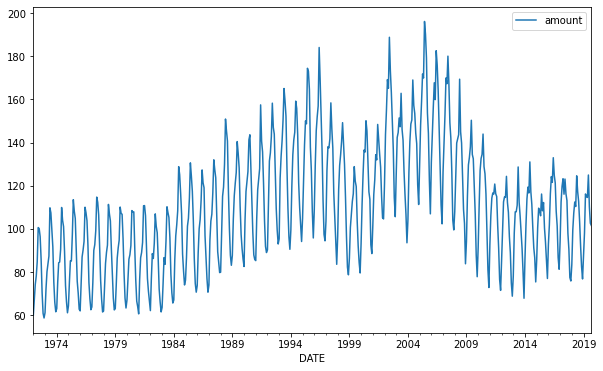

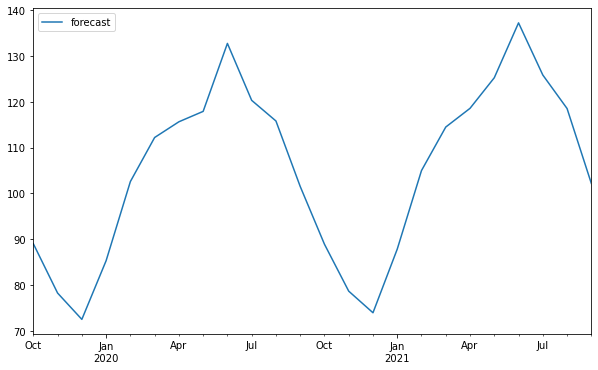

In [159]:
df.plot();
forecast_df.plot();

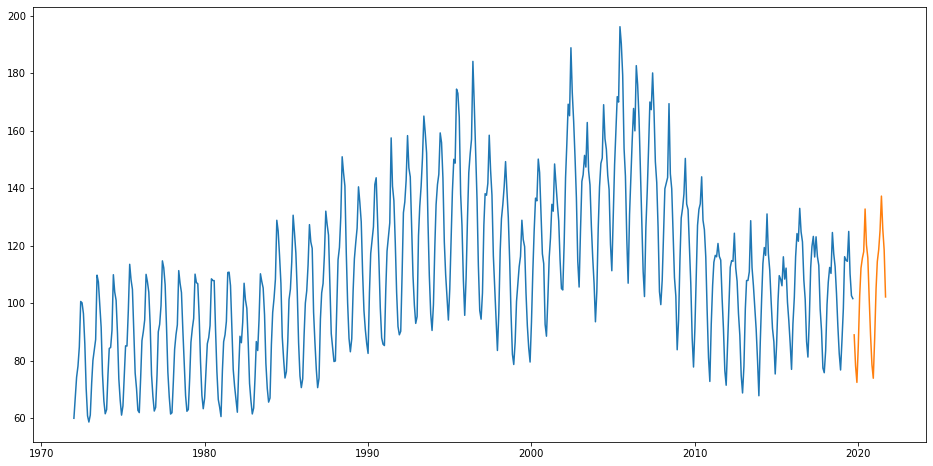

In [160]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['amount'])
plt.plot(forecast_df.index, forecast_df['forecast']);
#plt.plot(forecast_index, forecast)

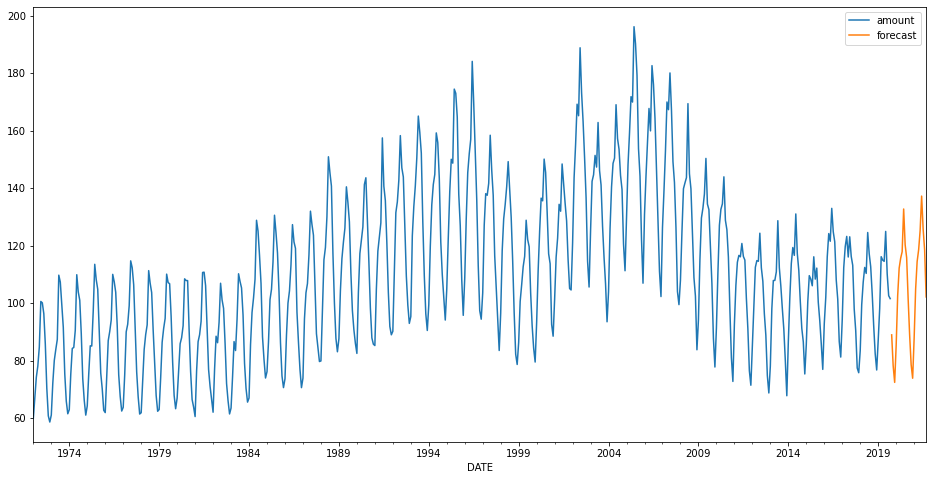

In [161]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

## Appx. Another approach: With actual human consuming behaviours in last 10 years

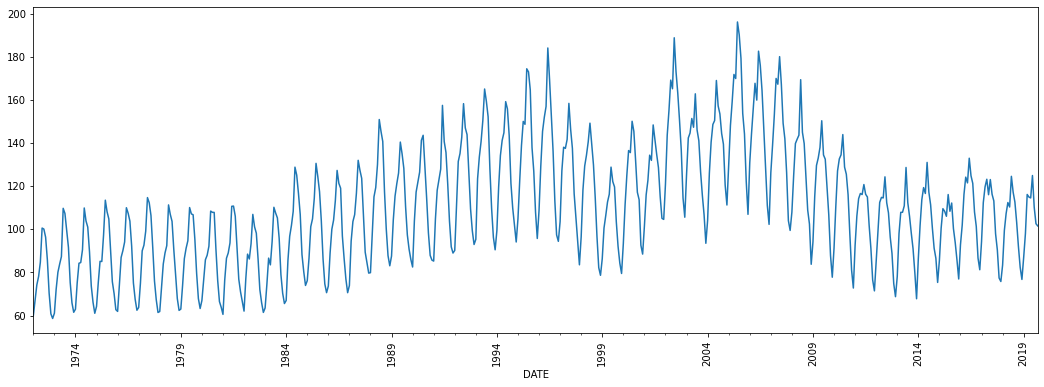

In [162]:
df['amount'].plot(figsize=(18,6))
plt.xticks(rotation=90);

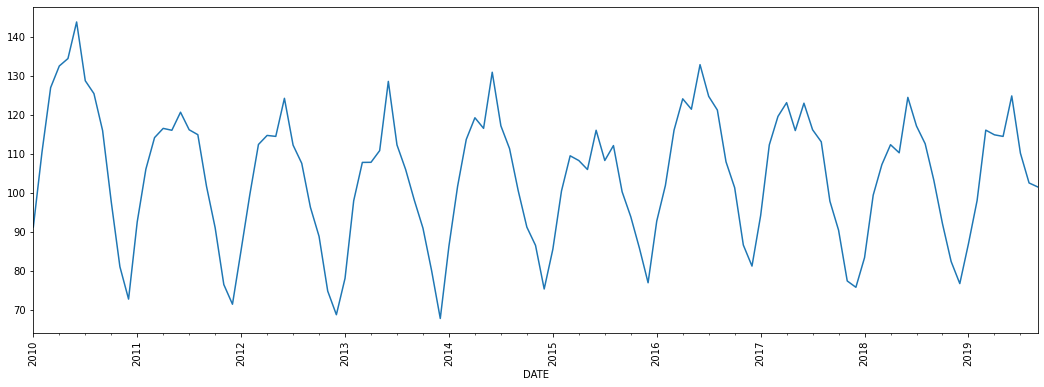

In [163]:
df['amount'].loc["2010-01-01" : "2019-09-01"].plot(figsize=(18,6))
plt.xticks(rotation=90);

In [164]:
df = df.loc["2010-01-01" : "2019-09-01"]
df.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


### Preprocessing of Data

### Train Test Split

In [166]:
len(df)

117

In [167]:
test_size = 36

In [168]:
test_ind = len(df)- test_size
test_ind

81

In [169]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [170]:
train.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


In [171]:
test.head()

,amount
DATE,
2016-10-01,101.384
2016-11-01,86.665
2016-12-01,81.257
2017-01-01,94.245
2017-02-01,112.388


### Scaling

In [172]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [173]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [174]:
# help(TimeseriesGenerator)

In [175]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [176]:
generator[0]

(array([[[-0.77649658],
         [ 0.32921347],
         [ 1.28456688],
         [ 1.60400421],
         [ 1.71398868],
         [ 2.25471882],
         [ 1.38584262],
         [ 1.19587938],
         [ 0.6497732 ],
         [-0.40451905],
         [-1.36374046],
         [-1.84188628]]]),
 array([[-0.70043185]]))

In [177]:
train_scaled[0:13]

array([[-0.77649658],
       [ 0.32921347],
       [ 1.28456688],
       [ 1.60400421],
       [ 1.71398868],
       [ 2.25471882],
       [ 1.38584262],
       [ 1.19587938],
       [ 0.6497732 ],
       [-0.40451905],
       [-1.36374046],
       [-1.84188628],
       [-0.70043185]])

In [178]:
X_act, y_act= generator[0]

In [179]:
print(f'Given the Array: \n{X_act.flatten()}')
print(f'Predict this y: \n {y_act}')

Given the Array: 
[-0.77649658  0.32921347  1.28456688  1.60400421  1.71398868  2.25471882
  1.38584262  1.19587938  0.6497732  -0.40451905 -1.36374046 -1.84188628]
Predict this y: 
 [[-0.70043185]]


## Modelling & Model Performance

### Creating Model

In [180]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
n_features = 1
model = Sequential()
model.add(LSTM(56, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1)) 
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 56)                12992     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 57        
Total params: 13,049
Trainable params: 13,049
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [181]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)
model.fit_generator(generator, epochs = 50,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/50
69/69 [==============================] - 7s 34ms/step - loss: 0.6408 - val_loss: 0.2082
Epoch 2/50
69/69 [==============================] - 1s 18ms/step - loss: 0.2320 - val_loss: 0.0763
Epoch 3/50
69/69 [==============================] - 1s 17ms/step - loss: 0.1126 - val_loss: 0.0973
Epoch 4/50
69/69 [==============================] - 1s 16ms/step - loss: 0.1147 - val_loss: 0.0890
Epoch 5/50
69/69 [==============================] - 1s 19ms/step - loss: 0.1047 - val_loss: 0.0934
Epoch 6/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0908 - val_loss: 0.1006
Epoch 7/50
69/69 [==============================] - 1s 18ms/step - loss: 0.1048 - val_loss: 0.1090
Epoch 8/50
69/69 [==============================] - 1s 18ms/step - loss: 0.1027 - val_loss: 0.0937
Epoch 9/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0926 - val_loss: 0.0917
Epoch 10/50
69/69 [==============================] - 1s 17ms/step - loss: 0.0883 - val_loss: 0.0903
Epoch 11/

<AxesSubplot:>

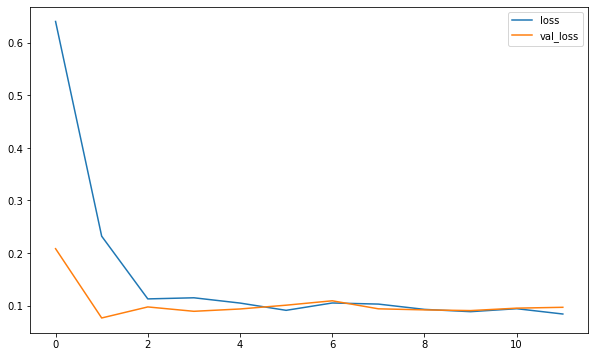

In [182]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [183]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)
y_pred = model.predict(validation_generator)
eval_metrics(test_scaled[12:], y_pred)

r2_score: 0.8682602724688339 
 mae: 0.23793852601207852 
 mse: 0.09659716004837197 
 rmse: 0.310800836627529


In [184]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
eval_metrics(test_scaled, test_predictions)

r2_score: 0.7537245726568031 
 mae: 0.34735182456959945 
 mse: 0.1775712924906124 
 rmse: 0.42139208878503215


#### Inverse Transformations and Comparing

In [185]:
true_predictions = scaler.inverse_transform(test_predictions)

In [186]:
test.head()

,amount
DATE,
2016-10-01,101.384
2016-11-01,86.665
2016-12-01,81.257
2017-01-01,94.245
2017-02-01,112.388


In [187]:
test['prediction'] = true_predictions

In [188]:
test

,amount,prediction
DATE,,
2016-10-01,101.384,97.636
2016-11-01,86.665,84.726
2016-12-01,81.257,76.702
2017-01-01,94.245,90.157
2017-02-01,112.388,100.777
2017-03-01,119.698,108.304
2017-04-01,123.228,113.392
2017-05-01,116.064,117.363
2017-06-01,123.087,120.684


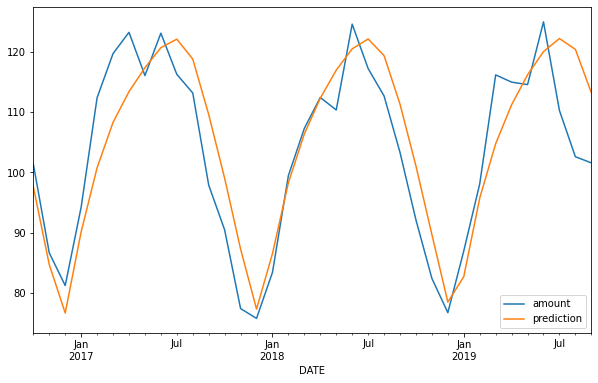

In [189]:
test.plot();

#### Calculation R2 Score and Error Metrics

In [190]:
eval_metrics(test.amount, test.prediction)

r2_score: 0.753724552120619 
 mae: 6.034668975830078 
 mse: 53.5970009409173 
 rmse: 7.320997264097105


## Retrain and Forecasting

In [191]:
test

,amount,prediction
DATE,,
2016-10-01,101.384,97.636
2016-11-01,86.665,84.726
2016-12-01,81.257,76.702
2017-01-01,94.245,90.157
2017-02-01,112.388,100.777
2017-03-01,119.698,108.304
2017-04-01,123.228,113.392
2017-05-01,116.064,117.363
2017-06-01,123.087,120.684


In [192]:
full_scaler = StandardScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [193]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [194]:
model = Sequential()

model.add(LSTM(56, activation = 'tanh', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=64)

Epoch 1/64
105/105 [==============================] - 6s 15ms/step - loss: 0.5612
Epoch 2/64
105/105 [==============================] - 2s 15ms/step - loss: 0.2028
Epoch 3/64
105/105 [==============================] - 2s 15ms/step - loss: 0.1361
Epoch 4/64
105/105 [==============================] - 2s 15ms/step - loss: 0.1294
Epoch 5/64
105/105 [==============================] - 2s 15ms/step - loss: 0.1151
Epoch 6/64
105/105 [==============================] - 1s 13ms/step - loss: 0.1023
Epoch 7/64
105/105 [==============================] - 1s 13ms/step - loss: 0.1047
Epoch 8/64
105/105 [==============================] - 1s 13ms/step - loss: 0.1078
Epoch 9/64
105/105 [==============================] - 1s 13ms/step - loss: 0.1044
Epoch 10/64
105/105 [==============================] - 1s 13ms/step - loss: 0.1024
Epoch 11/64
105/105 [==============================] - 1s 14ms/step - loss: 0.1006
Epoch 12/64
105/105 [==============================] - 1s 13ms/step - loss: 0.1103
Epoch 13/64
1

In [195]:
scaled_full_data.shape

(117, 1)

In [196]:
scaled_full_data[-length:].shape

(12, 1)

In [197]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:] 
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [198]:
forecast = scaler.inverse_transform(forecast)

In [199]:
forecast

array([[ 89.08158 ],
       [ 77.873146],
       [ 72.676315],
       [ 89.002556],
       [105.17025 ],
       [117.60928 ],
       [118.90503 ],
       [127.14115 ],
       [125.93294 ],
       [118.74364 ],
       [111.30691 ],
       [101.57709 ]], dtype=float32)

In [200]:
df.head()

,amount
DATE,
2010-01-01,91.290
2010-02-01,110.499
2010-03-01,127.097
2010-04-01,132.647
2010-05-01,134.558


In [201]:
forecast_index = pd.date_range(start = '2019-10-01', periods = periods, freq = 'MS')

In [202]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [203]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['forecast'])

In [204]:
forecast_df

,forecast
2019-10-01,89.082
2019-11-01,77.873
2019-12-01,72.676
2020-01-01,89.003
2020-02-01,105.170
2020-03-01,117.609
2020-04-01,118.905
2020-05-01,127.141
2020-06-01,125.933
2020-07-01,118.744


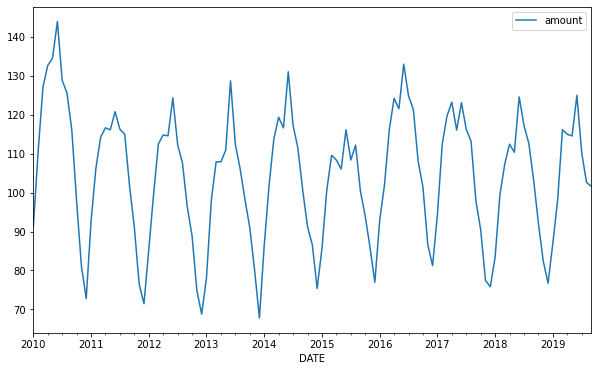

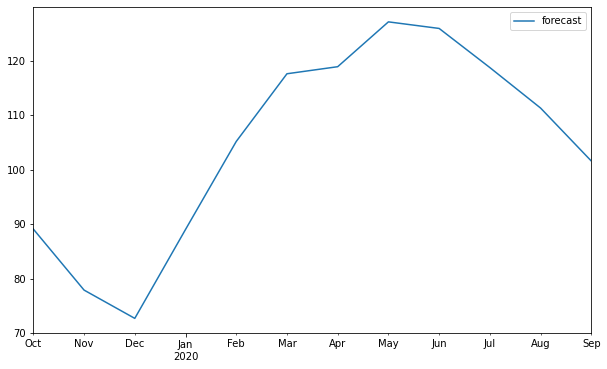

In [205]:
df.plot();
forecast_df.plot();

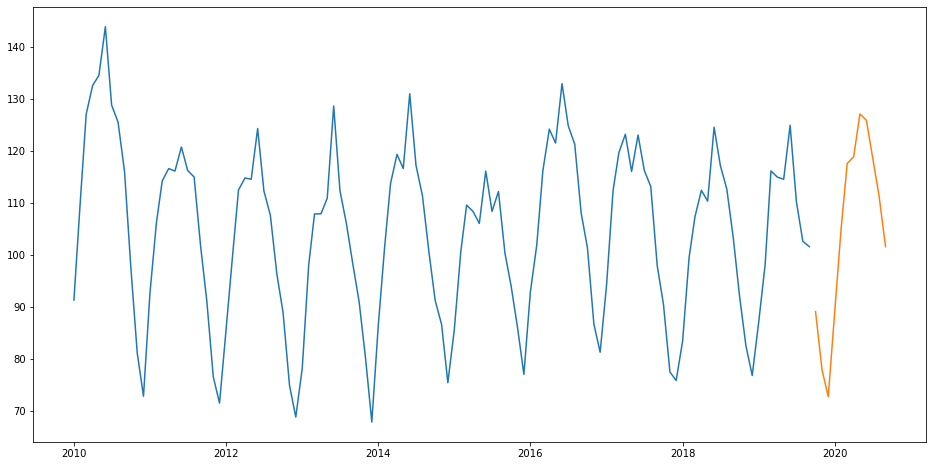

In [206]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['amount'])
plt.plot(forecast_df.index, forecast_df['forecast']);
#plt.plot(forecast_index, forecast)

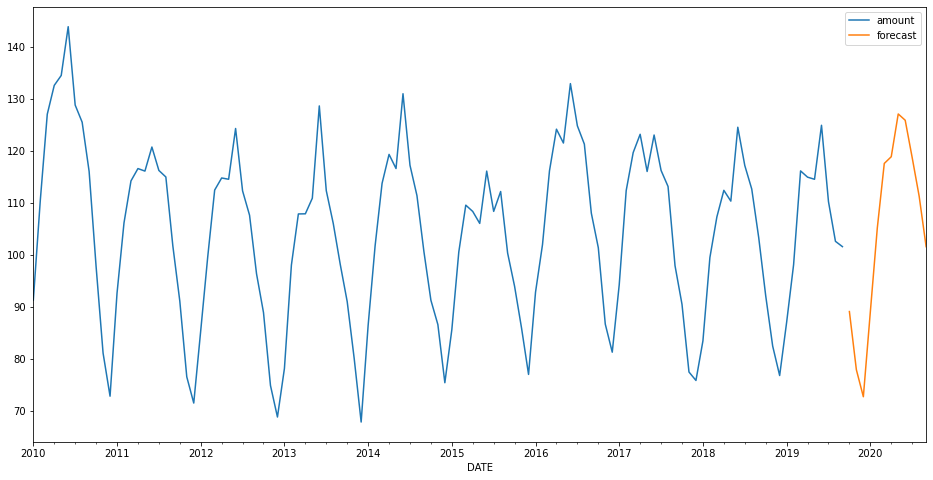

In [207]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));